# Ensemble Time Series

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import timeit

import warnings
warnings.filterwarnings("ignore")

# List of Stocks and ETFs
Provided by Thomas Choi.

In [2]:
stock_list = pd.read_csv("../stocks_and_etfs/stock_list.csv")
etf_list = pd.read_csv("../stocks_and_etfs/etf_list.csv")

In [3]:
import random

# Choose a random stock
stock_symbol = random.choice(stock_list.iloc[:,0])
print(stock_symbol)

FCX


## MySQL connection
Choosing one stock from SQL query to reduce query time.

In [4]:
import os
import sys
import mysql.connector

HOST="143.244.188.157"
PORT="3306"
USER="patrick-finProj"
PASSWORD="Pat#21$rick"

try: 
    conn = mysql.connector.connect(
        host=HOST,
        port=PORT,
        user=USER,
        password=PASSWORD,
        database="GlobalMarketData"
    )
    query = f"SELECT Date, Close, Open, High, Low, Volume from histdailyprice3 WHERE Symbol='{stock_symbol}';"
    histdailyprice3 = pd.read_sql(query, conn)
    conn.close()
except Exception as e:
    conn.close()
    print(str(e))

# Data

In [5]:
df = histdailyprice3.copy()
df.head()

,Date,Close,Open,High,Low,Volume
0,1998-01-01,7.875,7.875,7.875,7.875,0
1,1998-01-02,7.875,8.000,7.875,7.970,279300
2,1998-01-05,7.970,8.000,7.845,7.875,455300
3,1998-01-06,7.845,7.875,7.750,7.750,476200
4,1998-01-07,7.720,7.875,7.685,7.845,464100


# Select Features

In [33]:
input_feature = df[['Open', 'High', 'Low', 'Volume', 'Close']]
input_data = input_feature.values

# Normalize

In [34]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
input_data[:,:] = scaler.fit_transform(input_data[:,:])

In [36]:
lookback = 50
total_size=len(df)
X=[]
y=[]
for i in range(0, total_size-lookback):
    t=[]
    for j in range(0, lookback):
        current_index = i+j
        t.append(input_data[current_index, :])
    X.append(t)
    y.append(input_data[lookback+i, 4])

# Train-Test Split

In [37]:
test_size=100 # 100 days for testing data
X, y= np.array(X), np.array(y)
X_test = X[:test_size]
Y_test = y[:test_size]

X_work = X[test_size:]
y_work = y[test_size:]

validate_size = 10

X_valid = X[:validate_size]
y_valid = y[:validate_size]
X_train = X[validate_size:]
y_train = y[validate_size:]

In [38]:
# Reshape LSTM input layer
X_train = X_train.reshape(X_train.shape[0], lookback, 5)
X_valid = X_valid.reshape(X_valid.shape[0], lookback, 5)
X_test = X_test.reshape(X_test.shape[0], lookback, 5)
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(6117, 50, 5)
(10, 50, 5)
(100, 50, 5)


# Build LSTM Model

In [41]:
from keras import Sequential
from keras.layers import Dense, LSTM

model = Sequential()
model.add(LSTM(50, return_sequences= True, activation='relu', input_shape=(X.shape[1], 5)))
model.add(LSTM(50, return_sequences=True, activation='relu'))
model.add(LSTM(50))
model.add(Dense(1))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 50, 50)            11200     
                                                                 
 lstm_9 (LSTM)               (None, 50, 50)            20200     
                                                                 
 lstm_10 (LSTM)              (None, 50)                20200     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 51,651
Trainable params: 51,651
Non-trainable params: 0
_________________________________________________________________


# Callbacks
**EarlyStoping:** It will stop the traning if score of model didn't increase. This prevent model from overfitting. We are to set max in 10 epoches if it didn't increase then we will stop the training <br>
**ReduceLROnPlateau:** Use for reduce the learning rate. In 3 steps the score didn't increase we will reduce the learning rate to improve the training <br>
**ModelCheckpoint:** Use for save model only when the score increased

In [42]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model.h5', verbose=1, save_best_only=True, 
                    save_weights_only=True)
]

# Compile LSTM Model

In [43]:
model.compile(optimizer='adam', 
              loss='mean_squared_error', 
              metrics=['accuracy'])

In [44]:
start = timeit.default_timer()

model.fit(X_train, y_train, 
          epochs=100, batch_size=32, 
          validation_data=(X_valid, y_valid), callbacks=callbacks)

stop = timeit.default_timer()
print('Time: ', stop - start)

Epoch 1/100
192/192 [==============================] - ETA: 0s - loss: 0.0058 - accuracy: 3.2696e-04
Epoch 1: val_loss improved from inf to 0.00042, saving model to model.h5
192/192 [==============================] - 66s 327ms/step - loss: 0.0058 - accuracy: 3.2696e-04 - val_loss: 4.2474e-04 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
192/192 [==============================] - ETA: 0s - loss: 7.4934e-04 - accuracy: 3.2696e-04
Epoch 2: val_loss improved from 0.00042 to 0.00024, saving model to model.h5
192/192 [==============================] - 61s 319ms/step - loss: 7.4934e-04 - accuracy: 3.2696e-04 - val_loss: 2.4027e-04 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/100
192/192 [==============================] - ETA: 0s - loss: 5.2894e-04 - accuracy: 3.2696e-04
Epoch 3: val_loss improved from 0.00024 to 0.00020, saving model to model.h5
192/192 [==============================] - 61s 319ms/step - loss: 5.2894e-04 - accuracy: 3.2696e-04 - val_loss: 2.0237e-04 - val_accuracy: 0

# Prediction

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten

# Time the grid search
start = timeit.default_timer()

model = Sequential()
# Identifying the number of hidden neurons, the activation function,  and input shape
model.add(LSTM(512, activation='relu', 
               input_shape=(n_steps, n_features), 
               return_sequences=True))
# Adding a dropout layer to prevent overfitting
model.add(Dropout(0.2))
# Adding one more hidden layer with 256 neurons, with a relu activation function
model.add(LSTM(256,activation='relu'))
# Flattening the model to vectorize the three-dimensional matrix
model.add(Flatten())
# Adding an output layer with a linear activation function
model.add(Dense(1, activation='linear'))
# Compiling LSTM with Root Mean Square Propagation and mean squared error (MSE)
model.compile(optimizer='rmsprop', loss='mean_squared_error',
                       metrics=['mse'])

stop = timeit.default_timer()
print('Time: ', stop - start)

# Visualize prediction

In [45]:
predicted_value = model.predict(X_test)

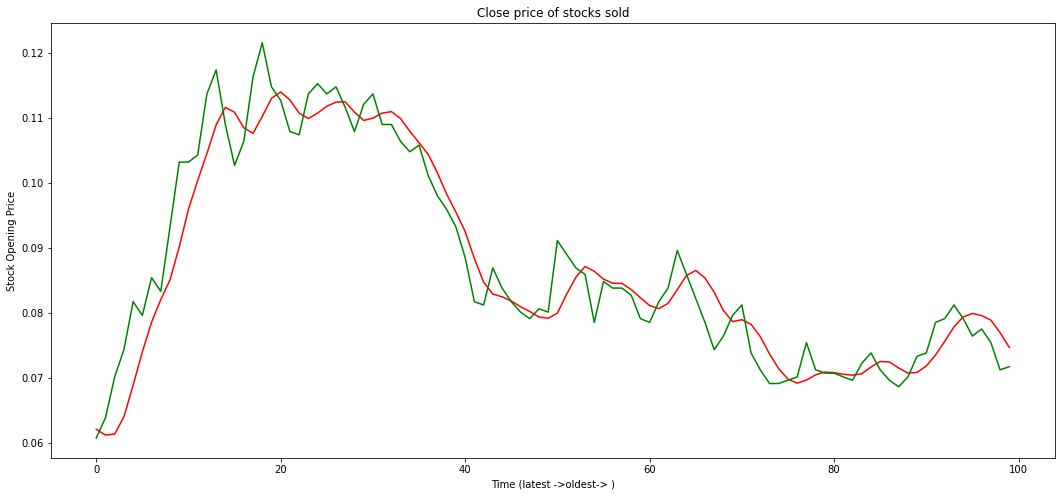

In [46]:
plt.figure(figsize=(18, 8))
plt.plot(predicted_value, color= 'red')
plt.plot(Y_test, color='green')
plt.title("Close price of stocks sold")
plt.xlabel("Time (latest ->oldest-> )")
plt.ylabel("Stock Opening Price")
plt.show()

In [12]:
history = model.fit(X_train, y_train,
                    epochs=400, batch_size=150, verbose=0,
                    validation_split = 0.10)

In [14]:
start = X_train[X_train.shape[0] - 13]
x_input = start
x_input = x_input.reshape((1, n_steps, n_features))

In [19]:
tempList = []
for i in range(len(diff_test)):
    x_input = x_input.reshape((1, n_steps, n_features))
    yhat = model.predict(x_input, verbose=0)
    x_input = np.append(x_input, yhat)
    x_input = x_input[1:]
    tempList.append(yhat)

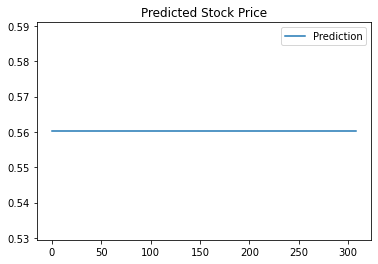

In [31]:
fig, ax = plt.subplots()
#ax.plot(diff_test, label='Actual Stock Price', linestyle='--')
ax.plot(np.array(tempList).flatten(),
        linestyle='solid', label="Prediction")
ax.set_title('Predicted Stock Price')
ax.legend(loc='best')
plt.show()